# Disciplina de Aprendizado de Máquina não supervisionado

## Aula 08

### Tópicos 

1. Opções para interpretação do resultado da clusterização
2. Ferramenta Orange
3. Considerações finais e fechamento

----




### Parte I: Interpretando e analisando resultados de uma *clusterização*

Uma vez que tenhamos o resultado de um agrupamento, além de utilizarmos medidas de avaliação internas (ou externas), uma tarefa importante consiste em compreender os *clusters* resultantes e o que levou o algoritmo a chegar em determinado resultado (i.e., configuração de *clusters*).

**Técnicas de visualização de dados** e **análise estatística (descritiva)** podem nos ajudar nessa tarefa de compreender os *clusters*, seus relacionamentos e o que há de especial em cada *cluster*, explicando o que os elementos de um *cluster* possuem em comum ou o quão diferentes eles são dos elementos de outros *clusters* (e porquê).

Em termos de visualização, podemos gerar gráficos como os que já criamos nas aulas anteriores. Podemos ainda gerar gráficos que indiquem proporção de elementos em cada cluster ou que ilustrem como estão concentradas ou distribuídas as variáveis nos diferentes clusters. Podemos ainda utilizar técnicas como PCA para analisar as variáveis e suas influências. 

Também podemos utilizar outras técnicas de aprendizado de máquina para nos auxiliar a entender como os *cluster* foram gerados ou como se dão as relações entre as variáveis (dimensões) de dados e os respectivos *clusters*. Por exemplo, se considerarmos que os *clusters* são as `classes-alvo` de um algoritmo de árvore de decisão, esse algoritmo pode ser usado para identificar as relações entre os dados e nos fornecer algum *insight*. Por exemplo, podemos usar `árvores de decisão` (e eventualmente `regras de associação`).

O processo se daria da seguinte forma: treinamos uma `árvore de decisão` no conjunto de dados usando os rótulos de *cluster* como variável-alvo e, em seguida, analisamos a árvore resultante para observar as regras sugeridas. Essa alternativa é interessante para conjuntos com poucas variáveis, pois árvores com muitas dimensões podem ficar muito grandes e difíceis de interpretar.

Para casos com muitas variáveis e uma variável destino binária (e.g., só dois *clusters*), uma opção seria treinar um modelo de regressão logística para prever os *clusters* e interpretar os coeficientes da regressão. Para problemas multiclasse, poderíamos ajustar um modelo de classificação para cada *cluster*, usando uma abordagem um-contra-todos, mas isso poderia tornar o processo bastante demorado. 

Vamos a um exemplo simples, para compreendermos a proposta, considerando nosso velho conhecido *dataset* `Iris`:

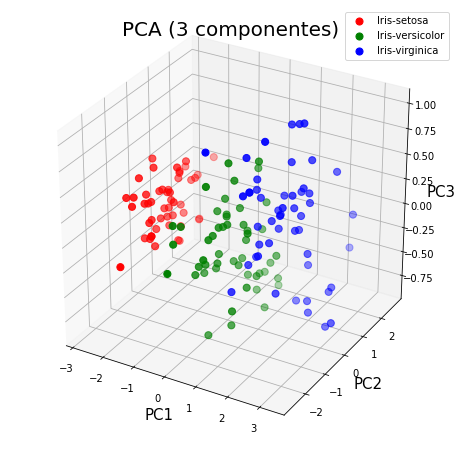

In [1]:
# carrega dataset Iris, normaliza e aplica PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
dados = df.loc[:, features].values
y = df.loc[:,['target']].values 

dados_normalizados = StandardScaler().fit_transform(dados)

pca3_model = PCA(n_components=3)
principalComponents = pca3_model.fit_transform(dados_normalizados)

principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('PCA (3 componentes)', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], 
               finalDf.loc[indicesToKeep, 'PC2'],
               finalDf.loc[indicesToKeep, 'PC3'],
               c = color, s = 50)
ax.legend(targets)
ax.grid()

Infere *clusters* com `k-means` e coloca resultado em um *dataframe*:

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import label_binarize

# já sabemos que são 3 clusters
km_model = KMeans(n_clusters=3, init="k-means++", n_init=100, max_iter=1000, random_state=0).fit(principalDf)
finalDf['k-means'] = kmeans = km_model.labels_
kmeans = finalDf.iloc[:,[4]]

Ilustra quantidade de elementos por classe original (*target*) versus resultado do *cluster* (*k-means*):


In [3]:
originais = finalDf.groupby(by='target')["target"].count()
clusters = finalDf.groupby(by='k-means')["k-means"].count()
resultado = pd.DataFrame([originais.values, clusters.values], index=['Target', 'k-means'])
resultado.T

,Target,k-means
0,50,53
1,50,50
2,50,47


Vamos criar uma árvore de decisão (`DecisionTreeClassifier`) para nos auxiliar a entender como os *clusters* são organizados em termos de *features* (variáveis/dimensões) e seus valores.

O código seguinte usa o módulo `DecisionTreeClassifier()` da biblioteca `sklearn` para criar uma árvore de decisão, tendo como alvo os clusters sugeridos pelo algoritmo `k-means` na etapa anterior.

Sugere-se a leitura da [documentação do módulo](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) e também do material "[Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)"

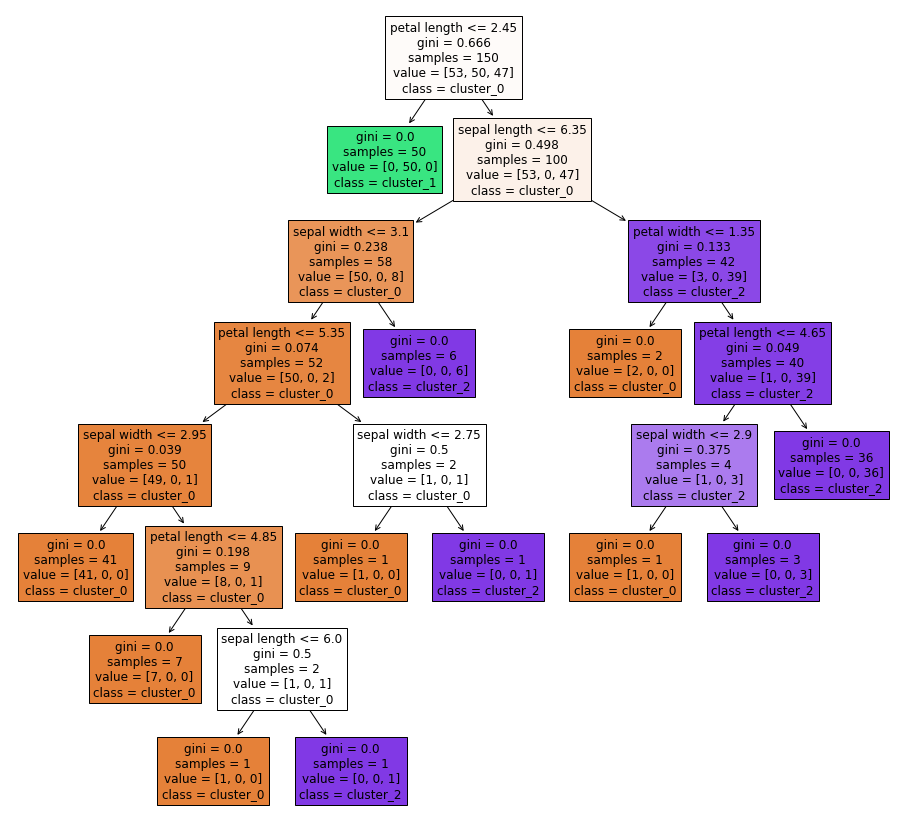

In [4]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(dados, kmeans)

plt.figure(figsize=(16,15))
tree.plot_tree(clf, feature_names=features, filled=True, class_names=[f"cluster_{str(i)}" for i in range(0,3)]) # proportion=True
plt.show()

Cada **nodo interno** contém o atributo que explica a decisão tomada (e qual foi ela). Por exemplo, o nodo raiz avalia `petal lenght`. Se o valor desse atributo for menor do que `2.45`, deve-se seguir para o filho esquerdo. Se for maior, segue-se para o lado direito. 

Os **nodos-folha** são os que não possuem filhos (e não têm nenhuma decisão a ser tomada). 

Todos os nodos (com exceção da raíz) indicam a quantidade de elementos (registros) que possuem as qualidades ou características naquele ponto. O caminho tomado na árvore até aquele ponto indica quais são os atributos e os respectivos valores que caracterizam os elementos até aquele ponto. 

Por exemplo, primeiro nodo tem um nodo-folha (o filho esquerdo) na cor verde que representa todo o `cluster 1`. Podemos perceber que se o `petal lenght <= 2.45`, garantidamente o elemento pertencerá ao `cluster 1`. Já para decidir quem faz parte dos outros clusters, temos que observar seu filho direito. Nele, os elementos que também tiverem `sepal lenght <= 6.35` são em grande parte do `cluster 0` (mas há alguns poucos elementos de outros *clusters*, se observarmos atentamente outros atributos nos ramos seguintes naquela bifurcação da árvore).

O [vídeo disponível aqui](https://youtu.be/_L39rN6gz7Y) explica como  árvores de decisão são criadas e como podem ser interpretadas.

Podemos gerar a árvore em forma de texto:

In [5]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=features)
print(r)

|--- petal length <= 2.45
|   |--- class: 1
|--- petal length >  2.45
|   |--- sepal length <= 6.35
|   |   |--- sepal width <= 3.10
|   |   |   |--- petal length <= 5.35
|   |   |   |   |--- sepal width <= 2.95
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- sepal width >  2.95
|   |   |   |   |   |--- petal length <= 4.85
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- petal length >  4.85
|   |   |   |   |   |   |--- sepal length <= 6.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- sepal length >  6.00
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |--- petal length >  5.35
|   |   |   |   |--- sepal width <= 2.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- sepal width >  2.75
|   |   |   |   |   |--- class: 2
|   |   |--- sepal width >  3.10
|   |   |   |--- class: 2
|   |--- sepal length >  6.35
|   |   |--- petal width <= 1.35
|   |   |   |--- class: 0
|   |   |--- petal width >  1.35
|   |   |   |--- petal length 

Existem algumas alternativas que exploram essa ideia acima. Por exemplo, o [SHapley Additive exPlanations (SHAP)](https://colab.research.google.com/drive/1KqJkEejHmiBjA2uzXUEIX_1ar4DtIRTI?usp=sharing).

Podemos, ainda, utilizar a biblioteca 'PyCaret` que automatiza *pipelines* de execução de processos de aprendizado de máquina. Além disso, ela possui alguns métodos interessantes para a análise dos resultados de um processo de clusterização.

In [6]:
# Após instalar, reinicie o ambiente, reexecute a célula inicial (de carga de dados) 
# e siga para a próxima célula (não instale novamente)
!pip install pycaret 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.3 MB/s 
     |████████████████████████████████| 1.7 MB 48.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 10.4 MB 41.8 MB/s 
     |████████████████████████████████| 3.3 MB 44.9 MB/s 
     |████████████████████████████████| 268 kB 63.1 MB/s 
     |████████████████████████████████| 6.8 MB 41.0 MB/s 
     |████████████████████████████████| 25.9 MB 74.4 MB/s 
     |████████████████████████████████| 167 kB 69.7 MB/s 
     |████████████████████████████████| 137 kB 54.1 MB/s 
     |████████████████████████████████| 2.0 MB 44.2 MB/s 
     |████████████████████████████████| 636 kB 49.3 MB/s 
     |████████████████████████████████| 88 kB 6.9 MB/s 
     |███████████████████████████████

In [3]:
import pandas as pandas
import seaborn as sns
from pandas_profiling import ProfileReport
from pycaret.clustering import *
from pycaret.datasets import get_data

In [4]:
df_dados = df.loc[:, features]
df_dados.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# Você pode criar uma amostra dos dados para fazer uma análise de quão robusto é o modelo
# aplicando primeiro no kmeans e depois aplicar nos dados de teste
df_dados_treinamento = df_dados.sample(frac=0.95, random_state=123)
df_dados_teste = df_dados.drop(df_dados_treinamento.index)
df_dados_treinamento.reset_index(drop=True,inplace=True)
df_dados_teste.reset_index(drop=True,inplace=True)

A biblioteca [`PyCaret`](https://pycaret.org/) cria um contexto de execução e o primeiro passo consiste em configurar esse contexto de execução. A linha seguinte faz isso. 

Nela indicamos os dados a serem processados no *pipeline*. Também podemos indicar algumas etapas de preprocessamento (no exemplo, vamos normalizar os dados usando o método `minmax`). Há diversas opções - leia a [página de documentação](https://pycaret.gitbook.io/docs/) da biblioteca caso queira utilizá-la.

In [6]:
# execute e atente para as mensagens
# em uma delas você deve confirmar a configuração pressionando [ENTER]
configuracao = setup(data=df_dados, session_id=1, normalize=True, normalize_method='minmax')

,Description,Value
0,session_id,1
1,Original Data,"(150, 4)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(150, 4)"
9,CPU Jobs,-1


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='UNSUPERVIS

Podemos pedir para ele mostrar os modelos disponíveis para uso:

In [7]:
models()

INFO:logs:gpu_param set to False


,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


Podemos criar solicitar a criação e o ajuste do modelo. Ele já calcula os resultados para nós:

In [8]:
kmeans_model = create_model('kmeans', num_clusters=3) # se não passar num_clusters, executa várias vezes e sugere o ideal com base no método de elbow

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5043,358.5672,0.761,0,0,0


INFO:logs:create_model_container: 1
INFO:logs:master_model_container: 1
INFO:logs:display_container: 2
INFO:logs:KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)
INFO:logs:create_model() succesfully completed......................................


In [9]:
# mostra os hiperparâmetros
print(kmeans_model)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)


Recupera os resultados (e mostra na tela alguns):

In [10]:
kmeans_results = assign_model(kmeans_model)
kmeans_results.head()

INFO:logs:Initializing assign_model()
INFO:logs:assign_model(model=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0), transformation=False, score=True, verbose=True)
INFO:logs:Checking exceptions
INFO:logs:Determining Trained Model
INFO:logs:Trained Model : K-Means Clustering
INFO:logs:Copying data
INFO:logs:(150, 5)
INFO:logs:assign_model() succesfully completed......................................


,sepal length,sepal width,petal length,petal width,Cluster
0,5.1,3.5,1.4,0.2,Cluster 1
1,4.9,3.0,1.4,0.2,Cluster 1
2,4.7,3.2,1.3,0.2,Cluster 1
3,4.6,3.1,1.5,0.2,Cluster 1
4,5.0,3.6,1.4,0.2,Cluster 1


Podemos solicitar gráficos com diferentes métricas.

Por exemplo, o resultado do teste do cotovelo:

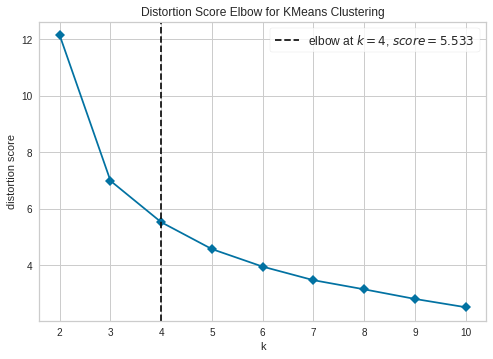

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [11]:
plot_model(kmeans_model, plot='elbow')

O gráfico de `Silhouette`:

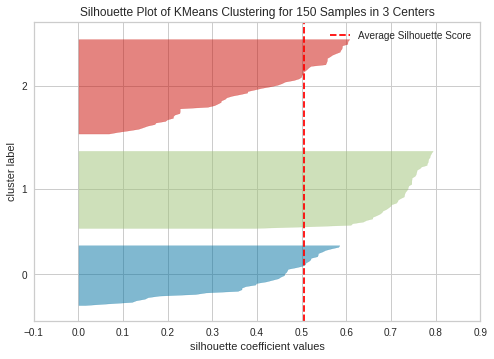

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [12]:
plot_model(kmeans_model, plot='silhouette')

Podemos comparar os resultados, por pares de variáveis:

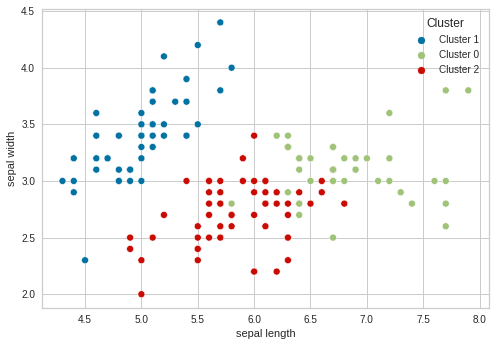

In [13]:
sns.scatterplot(data=kmeans_results, x='sepal length', y='sepal width', hue='Cluster')

Podemos visualizar os dados em um *embedding* de 2 dimensões (usando `PCA` como base):

In [14]:
plot_model(kmeans_model)

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


Podemos usar `t-SNE` para criar o embedding em 3D:

In [15]:
plot_model(kmeans_model, plot='tsne')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


Há a opção de mostrar um [Mapa de Distância entre *clusters*](https://www.scikit-yb.org/en/latest/api/cluster/icdm.html).

Nesse caso, é importante mencionar que esses mapas exibem um *embedding* dos centros de *cluster* em 2 dimensões, tendo como base `MDS`, com a distância para outros centros preservada. Por exemplo. quanto mais próximos os estiverem uns dos outros na visualização, mais próximos estarão do espaço original. Os *clusters* são dimensionados de acordo com alguma métrica, que por padrão é a associação, i.e., a quantidade de elementos que pertencem a cada *cluster*. Isso dá uma noção da importância relativa dos *clusters*. No entanto, caso dois *clusters* se sobreponham no espaço 2D, isso não implica que eles se sobreponham no espaço original.

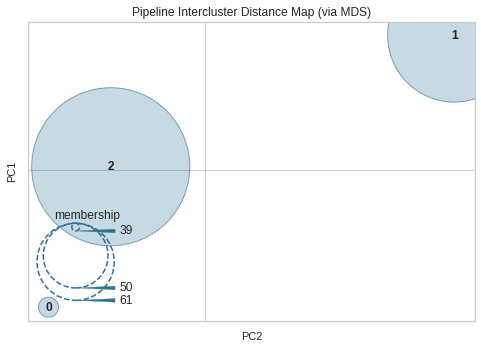

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [16]:
plot_model(kmeans_model, plot='distance')

Podemos observar a distribuição de elementos por clusters:

In [17]:
plot_model(kmeans_model, plot='distribution')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


Podemos, ainda, fazer análises detalhadas por variáveis:

In [18]:
plot_model(kmeans_model, plot='distribution', feature='petal length')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [19]:
plot_model(kmeans_model, plot='distribution', feature='petal width')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [20]:
plot_model(kmeans_model, plot='distribution', feature='sepal length')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [21]:
plot_model(kmeans_model, plot='distribution', feature='sepal width')

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


---
**Exercício**: O código seguinte carrega o *dataset* com os dados de Pinguins.

Utilize a biblioteca `PyCarret` para clusterizar esses dados. Deixe que ela escolha automaticamente a quantidade de clusters. Se necessário, remova ou converta variáveis categóricas.

Analise a qualidade dos resultados usando métricas intrínsecas.

Avalie a distribuição das variáveis, buscando identificar quais são exclusivas de clusters e quais são comuns a mais de um cluster. 

**Desafio**: Crie uma árvore de decisão e tente fazer uma análise mais detalhada, considerando os resultados da árvore. Use uma árvore do tipo RandomForest, que é mais precisa.

In [22]:
pinguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
pinguins = pinguins.dropna() # remove registros com dados faltantes

In [23]:
# remover a espécie
type(pinguins)

pandas.core.frame.DataFrame

In [25]:
pinguins
# remove atributos categóricos
pinguins_dados = pinguins.drop(['species', 'island', 'sex'], axis=1)

In [26]:
# execute e atente para as mensagens
# em uma delas você deve confirmar a configuração pressionando [ENTER]
configuracao_pinguins = setup(data=pinguins_dados, session_id=1, normalize=True, normalize_method='minmax')

,Description,Value
0,session_id,1
1,Original Data,"(333, 5)"
2,Missing Values,False
3,Numeric Features,4
4,Categorical Features,1
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(333, 7)"
9,CPU Jobs,-1


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[],
                                      target='UNSUPERVISED_DUMMY_TARGET',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='most frequent',
                                fill_value_categorical=None,
                                fill_value_numerical=None...
                ('P_transform', 'passthrough'), ('binn', 'passthrough'),
                ('rem_outliers', 'passthrough'), ('cluster_all', 'passthrough'),
                ('dummy', Dummify(target='UNSUPERVIS

In [28]:
kmeans_model = create_model('kmeans')
print(kmeans_model)
# n_clusters indicado = 4

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5859,496.3449,0.6496,0,0,0


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)
INFO:logs:create_model() succesfully completed......................................


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0)


In [29]:
kmeans_results = assign_model(kmeans_model)
kmeans_results.head()

INFO:logs:Initializing assign_model()
INFO:logs:assign_model(model=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=1, tol=0.0001, verbose=0), transformation=False, score=True, verbose=True)
INFO:logs:Checking exceptions
INFO:logs:Determining Trained Model
INFO:logs:Trained Model : K-Means Clustering
INFO:logs:Copying data
INFO:logs:(333, 6)
INFO:logs:assign_model() succesfully completed......................................


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,Cluster
0,39.1,18.7,181.0,3750.0,2007,Cluster 2
1,39.5,17.4,186.0,3800.0,2007,Cluster 2
2,40.3,18.0,195.0,3250.0,2007,Cluster 2
4,36.7,19.3,193.0,3450.0,2007,Cluster 2
5,39.3,20.6,190.0,3650.0,2007,Cluster 2


Análise por variáveis:

In [33]:
plot_model(kmeans_model, plot='distribution', feature='bill_length_mm')
# Análise:
# Nenhuma faixa de valores dessa variável parece ser exclusiva de um único cluster

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [34]:
plot_model(kmeans_model, plot='distribution', feature='bill_depth_mm')

# Análise:
# Nenhuma faixa de valores dessa variável parece ser exclusiva de um único cluster
# O Cluster 3 não apresenta valores maiores que 18
# O Cluster 0 não apresenta valores menores que 15

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [35]:
plot_model(kmeans_model, plot='distribution', feature='flipper_length_mm')

# Análise:
# Nenhuma faixa de valores dessa variável parece ser exclusiva de um único cluster
# O Cluster 3 não apresenta valores menores que 200
# O Cluster 0 não apresenta valores maiores que 220

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [36]:
plot_model(kmeans_model, plot='distribution', feature='body_mass_g')

# Análise:
# Nenhuma faixa de valores dessa variável parece ser exclusiva de um único cluster
# O Cluster 3 não apresenta valores menores que 4200
# O Cluster 0 não apresenta valores maiores que 4500

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [37]:
plot_model(kmeans_model, plot='distribution', feature='year')

# Análise:
# Existem faixas de valores exclusivas de um único cluster
# O Cluster 2 é unico para o valor 2007
# O Cluster 2 é unico para o valor 2008
# O Cluster 0 e 3 aparecem para o valor 2009

INFO:logs:Rendering Visual


INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


---

## Fechamento

### Visão geral do processo

1. Carregar dados, selecionar objetos (elementos) a *clusterizar* (eventualmente será necessário realizar alguma amostragem representativa, se o conjunto for muito grande, ou para fazer validação cruzada); 
2. Realizar limpeza (p.ex., remover `NAs`) e eventualmente transformar dados (definir o que fazer com dados categóricos, avaliar se será necessário discretizar dados contínuos);
3. Selecionar variáveis. Variáveis só devem ser incluídas se existir uma boa razão para elas auxiliarem na definição dos *clusters*. Eventualmente pode ser necessário avaliar as propriedades das dimensões (distribuição, variância...) e eventualmente remover as que não possuem muita capacidade de discriminação (lembrar do exemplo das *stopwords* em textos);
4. Padronizar dimensões;
5. Aplicar alguma técnica de redução de dimensionalidade (PCA, MDS, UMAP);
6. *Clusterizar* (definir medida de similaridade e método de agrupamento); 
7. Avaliar resultado considerando alguma métrica interna (e, se tiver algum conhecimento prévio, fazer avaliação externa também);
5. Analisar resultados através de técnicas de análise (visual) de atributos e uso de estatística descritiva e comparativa, por *clusters*;
6. Repetir o processo com outros dados (outras amostras, para confirmar resultados, ou por perturbação dos dados, para averiguar se os *clusters* são mantidos e verificar quão robusta é a solução) ou com outras técnicas de agrupamento.

### Considerações finais da disciplina

Clusterização é um tipo de Análise Exploratória.

É geralmente difícil, a priori, antecipar que combinação de variáveis, medidas de similaridade e técnicas de agrupamento levarão a classificações informativas e interessantes.

Existe um conjunto de passos que podemos seguir, mas o pesquisador deve intervir toda vez que for necessário a fim de alterar as variáveis, escolher medidas de similaridade diferentes, concentrar-se em um conjunto particular de elementos, entre outras opções.

Ao final, podemos utilizar instrumentos que nos auxiliem a avaliar e interpretar os resultados, incluindo métricas de qualidade interna e até externas (se *baseline* estiver disponível). O mais importante é conseguirmos verificar se os clusters resultantes são reais ou meramente artefatos resultantes dos algoritmos, já que há diferentes métodos e alguns podem ser mais adequados do que outros, dependendo das propriedades do conjunto de dados. Precisamos avaliar se há outras opções, melhores. E se há alguma explicação convincente para os clusters.  Eventualmente, podemos aplicar vários métodos e verificar se os resultados produzidos são semelhantes, ampliando nossa confiança nos resultados (ou ao menos indicando se vale a pena investigá-los mais a fundo).

---

### Extras: Orange

[Orange](https://orangedatamining.com/) é um ambiente visual de programação de processos de aprendizado de máquina. O ambiente é desenvolvido em Python. Ele possui [código aberto](https://github.com/biolab/orange3) e é de uso livre. Tem um conjunto de bibliotecas básicas com os principais algoritmos, mas pode ser facilmente estendido com scripts Python, se necessário. 